In [1]:
from pylab import *
import pandas as pd
from sklearn import datasets
%matplotlib inline

# 1. Load log file

In [2]:
machine = 'ryzen'


with open("../log/{}_toyDetector.log".format(machine)) as f:
    lines = f.readlines()

In [3]:
def getProf():
    HToD,DtoH,k1,k2,k3,k4,k5,memset = [],[],[],[],[],[],[],[]
    
    for line in lines:  
        wordsInLine = line.split("  ")

        if wordsInLine[-1] == "[CUDA memcpy HtoD]\n":
            word = wordsInLine[-8]
            time = float(word[:-2])
            if word[-2:] == "us":
                time /= 1000
            HToD.append(time)

        if wordsInLine[-1] == "[CUDA memcpy DtoH]\n":
            word = wordsInLine[-8]
            time = float(word[:-2])
            if word[-2:] == "us":
                time /= 1000
            DtoH.append(time)

        if wordsInLine[-1] == "cudaMemset\n":
            word = wordsInLine[-8]
            time = float(word[:-2])
            if word[-2:] == "us":
                time /= 1000
            memset.append(time)
            
        name = "kernel_compute_histogram"
        if wordsInLine[-1][:len(name)] == name:
            word = wordsInLine[-8]
            time = float(word[:-2])
            if word[-2:] == "us":
                time /= 1000
            k1.append(time)

        name = "kernel_compute_density"
        if wordsInLine[-1][:len(name)] == name:
            word = wordsInLine[-8]
            time = float(word[:-2])
            if word[-2:] == "us":
                time /= 1000
            k2.append(time)

        name = "kernel_compute_distanceToHigher"
        if wordsInLine[-1][:len(name)] == name:
            word = wordsInLine[-8]
            time = float(word[:-2])
            if word[-2:] == "us":
                time /= 1000
            k3.append(time)

        name = "kernel_find_clusters"
        if wordsInLine[-1][:len(name)] == name:
            word = wordsInLine[-8]
            time = float(word[:-2])
            if word[-2:] == "us":
                time /= 1000
            k4.append(time)

        name = "kernel_assign_clusters"
        if wordsInLine[-1][:len(name)] == name:
            word = wordsInLine[-8]
            time = float(word[:-2])
            if word[-2:] == "us":
                time /= 1000
            k5.append(time)
        
    prof = np.array([HToD,DtoH,memset,k1,k2,k3,k4,k5]).T
    return prof


compileStatus = 0
for l,thisline in enumerate(lines):

    if thisline == "running with CPU\n":
        compileStatus = 1
        times = []
    if thisline == "running with GPU\n":
        df = pd.DataFrame.from_records([times],columns=np.arange(1000,10001,1000),index=["CPU"])
        compileStatus = 2
        times = []
    if thisline == "running with GPU with nvprof\n":

        df = df.append(pd.DataFrame.from_records([times],columns=np.arange(1000,10001,1000),index=["GPUTotal"]))
        prof = getProf()
        df = df.append(pd.DataFrame.from_records([prof.reshape(10,8,-1)],columns=np.arange(1000,10001,1000),index=["GPUProf"]))

        compileStatus = 3
        times = []
    if thisline == "running with CUPLA CPU TBB\n":
        #df.append(pd.DataFrame.from_records([times],columns=np.arange(1000,10001,1000),index=["CPU"]))
        compileStatus = 4
        times = []
    if thisline == "running with CUPLA CPU Serial\n":
        df = df.append( pd.DataFrame.from_records([times],columns=np.arange(1000,10001,1000),index=["CUPLATBB"]))
        compileStatus = 5
        times = []
    if thisline == "running with CUPLA CUDA\n":
        df = df.append( pd.DataFrame.from_records([times],columns=np.arange(1000,10001,1000),index=["CUPLASerial"]))
        compileStatus = 6
        times = []
    if l == len(lines)-1:
        df = df.append( pd.DataFrame.from_records([times],columns=np.arange(1000,10001,1000),index=["CUPLACUDA"]))


    if thisline == "Start to run CLUE algorithm\n":
        time = []

    if thisline[0:13]=="Elapsed time:":
        if compileStatus in [1,4,5]:
            temp = [float(lines[l+nl][31:-3]) for nl in range(-5,0)] + [float(thisline[13:-3])]
            time.append(temp)
        if compileStatus in [2,6]:
            temp = [float(thisline[13:-3])]
            time.append(temp)



    if thisline == "Finished running CLUE algorithm\n":
        if compileStatus in [1,2,4,5,6]:
            time = np.array(time).T
            times.append(time)

# 2. Plot

In [4]:
cpu = np.array([df.loc["CPU",c][-1] for c in df.columns])
gpu = np.array([df.loc["GPUTotal",c][-1] for c in df.columns])
prof = np.array([df.loc["GPUProf",c][:,0] for c in df.columns]).T/100
cuplaTBB = np.array([df.loc["CUPLATBB",c][-1] for c in df.columns])

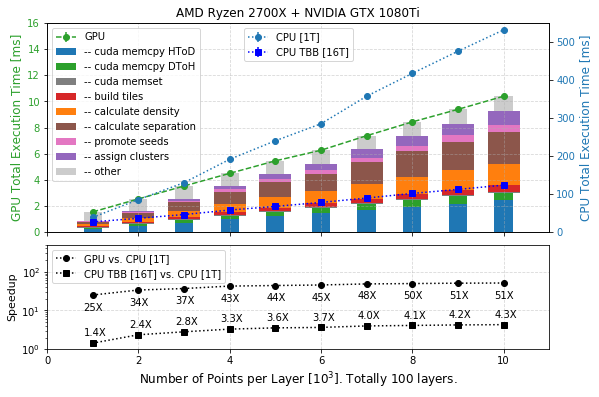

In [5]:
fig, axex = plt.subplots( 2,1, sharex=True, figsize=(9,6),facecolor='w',gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(hspace=0.08)

n = np.arange(1,11,1)

##########################
ax1= axex[0]
ax2 = ax1.twinx()

ax1.errorbar(n, gpu.mean(axis=1),yerr=gpu.std(axis=1), marker='o',linestyle='--',color='C2',label=r'GPU')
but = np.cumsum(prof,axis=0)
labels = [
          "-- cuda memcpy HToD",
          "-- cuda memcpy DToH",
          "-- cuda memset",
          "-- build tiles",
          "-- calculate density",
          "-- calculate separation",
          "-- promote seeds",
          "-- assign clusters",
          "-- other"
         ]

colors = ["C0", "C2", "C7","C3","C1","C5", "C6","C4", "0.8" ]


ax1.bar(n, prof[0],label= labels[0],width=0.4, facecolor=colors[0])
ax1.bar(n, prof[1], bottom=but[0],label= labels[1],width=0.4, facecolor=colors[1] )
for i in range(2,8):
    ax1.bar(n, prof[i], bottom=but[i-1],label= labels[i],width=0.7, facecolor=colors[i] )
other = gpu.mean(axis=1) - but[7]
ax1.bar(n, other, bottom=but[7],width=0.4,label= labels[8], facecolor=colors[8] )

ax1.set_ylim(0,16)
ax1.set_xlim(0,11)
ax1.grid(linestyle='--',alpha=0.5)
ax1.legend(fontsize=10)

ax1.set_ylabel("GPU Total Execution Time [ms]",fontsize=12,color="C2")
ax1.tick_params(axis='y', labelcolor="C2")
ax1.set_title("AMD Ryzen 2700X + NVIDIA GTX 1080Ti",fontsize=12)

ax2.errorbar(n, cpu.mean(axis=1),yerr=cpu.std(axis=1), marker='o',linestyle=':',color="C0",label=r'CPU [1T]')
ax2.errorbar(n, cuplaTBB.mean(axis=1),yerr=cuplaTBB.std(axis=1), marker='s',linestyle=':',color="b",label=r'CPU TBB [16T]')
ax2.legend(fontsize=10,loc="upper center")
ax2.set_ylim(0,550)
ax2.tick_params(axis='y', labelcolor="C0")
ax2.set_ylabel("CPU Total Execution Time [ms]",fontsize=12,color="C0")

##########################
ax3 = axex[1]
speedup= cpu.mean(axis=1)/gpu.mean(axis=1)
ax3.plot(n, speedup, marker='o',linestyle=':',color="k",label='GPU vs. CPU [1T]')

for i in range(n.size):
    ax3.text(n[i]-0.2,speedup[i]/2.5,"{:2.0f}X".format(speedup[i]))
    

speedup= cpu.mean(axis=1)/cuplaTBB.mean(axis=1)
ax3.plot(n, speedup, marker='s',linestyle=':',color="k",label='CPU TBB [16T] vs. CPU [1T]')
for i in range(n.size):
    ax3.text(n[i]-0.2,speedup[i]*1.5,"{:3.1f}X".format(speedup[i]))
    
ax3.set_xlabel(r"Number of Points per Layer [$10^3$]. Totally 100 layers.",fontsize=12)
ax3.legend(fontsize=10, loc="upper left")
ax3.set_ylabel("Speedup",fontsize=11,color="k")
ax3.set_ylim(1,500)
ax3.grid(linestyle='--',alpha=0.5)
ax3.set_yscale("log")

plt.savefig("../plots/Figure5.pdf")
plt.savefig("../plots/Figure5.png",dpi=400)

# fully decomsited

In [5]:
cpuMeans = np.array([df.loc["CPU",c].mean(axis=1) for c in df.columns]).T
cuplaTBBMeans = np.array([df.loc["CUPLATBB",c].mean(axis=1) for c in df.columns]).T

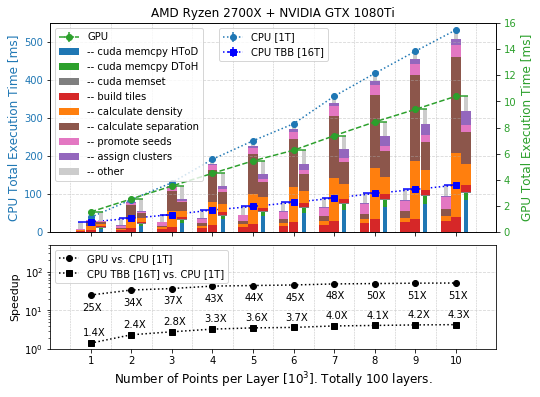

In [11]:
fig, axex = plt.subplots( 2,1, sharex=True, figsize=(8,6),facecolor='w',gridspec_kw={'height_ratios':[2,1]})
fig.subplots_adjust(hspace=0.08)

n = np.arange(1,11,1)

##########################
ax1= axex[0]
ax2 = ax1.twinx()


labels = [
          "-- cuda memcpy HToD",
          "-- cuda memcpy DToH",
          "-- cuda memset",
          "-- build tiles",
          "-- calculate density",
          "-- calculate separation",
          "-- promote seeds",
          "-- assign clusters",
          "-- other"
         ]

colors = ["C0", "C2", "C7","C3","C1","C5", "C6","C4", "0.8" ]

ax2.errorbar(n, gpu.mean(axis=1),yerr=gpu.std(axis=1),xerr=np.c_[np.array([0]*10),np.array([0.3]*10)].T, marker='o',linestyle='--',color='C2',label=r'GPU')
but = np.cumsum(prof,axis=0)
ax2.bar(n+0.25, prof[0],label= labels[0],width=0.1, facecolor=colors[0])
ax2.bar(n+0.25, prof[1], bottom=but[0],label= labels[1], width=0.1, facecolor=colors[1] )
for i in range(2,8):
    ax2.bar(n+0.25, prof[i], bottom=but[i-1],label= labels[i],width=0.24, facecolor=colors[i] )
other = gpu.mean(axis=1) - but[7]
ax2.bar(n+0.25, other, bottom=but[7],width=0.1,label= labels[8], facecolor=colors[8] )

ax2.set_ylim(0,16)
ax2.set_xlim(0,11)
ax2.legend(fontsize=10)

ax2.set_ylabel("GPU Total Execution Time [ms]",fontsize=12,color="C2")
ax2.tick_params(axis='y', labelcolor="C2")
ax2.set_title("AMD Ryzen 2700X + NVIDIA GTX 1080Ti",fontsize=12)

ax1.errorbar(n, cpu.mean(axis=1),yerr=cpu.std(axis=1), marker='o',linestyle=':',color="C0",label=r'CPU [1T]')
but = np.cumsum(cpuMeans,axis=0) 
for i in range(5):
    ax1.bar(n, cpuMeans[i] ,bottom=but[i]-cpuMeans[i],width=0.24, facecolor=colors[i+3] )
ax1.bar(n, cpuMeans[-1]-but[4], bottom=but[4],width=0.1, facecolor=colors[5+3] )

ax1.errorbar(n, cuplaTBB.mean(axis=1), yerr=cuplaTBB.std(axis=1) ,xerr=np.c_[np.array([0.3]*10),np.array([0]*10)].T, marker='s',linestyle=':',color="b",label=r'CPU TBB [16T]')
but = np.cumsum(cuplaTBBMeans,axis=0) 
for i in range(5):
    ax1.bar(n-0.25, cuplaTBBMeans[i], bottom=but[i]-cuplaTBBMeans[i],width=0.24, facecolor=colors[i+3] )
ax1.bar(n-0.25,  cuplaTBBMeans[-1]-but[4], bottom=but[4],width=0.1, facecolor=colors[5+3] )

    
ax1.legend(fontsize=10,loc="upper center")
ax1.set_ylim(0,550)
ax1.tick_params(axis='y', labelcolor="C0")
ax1.set_ylabel("CPU Total Execution Time [ms]",fontsize=12,color="C0")
for xx in range(12):
    ax1.axvline(xx-0.5,linestyle='--',c='grey',lw=0.5,alpha=0.5)
ax1.grid(linestyle='--',axis='y',alpha=0.5)

##########################
ax3 = axex[1]
speedup= cpu.mean(axis=1)/gpu.mean(axis=1)
ax3.plot(n, speedup, marker='o',linestyle=':',color="k",label='GPU vs. CPU [1T]')

for i in range(n.size):
    ax3.text(n[i]-0.2,speedup[i]/2.5,"{:2.0f}X".format(speedup[i]))
    

speedup= cpu.mean(axis=1)/cuplaTBB.mean(axis=1)
ax3.plot(n, speedup, marker='s',linestyle=':',color="k",label='CPU TBB [16T] vs. CPU [1T]')
for i in range(n.size):
    ax3.text(n[i]-0.2,speedup[i]*1.5,"{:3.1f}X".format(speedup[i]))
    
ax3.set_xlabel(r"Number of Points per Layer [$10^3$]. Totally 100 layers.",fontsize=12)
ax3.legend(fontsize=10, loc="upper left")
ax3.set_ylabel("Speedup",fontsize=11,color="k")
ax3.set_ylim(1,500)
ax3.grid(linestyle='--',axis='y',alpha=0.5)
ax3.set_yscale("log")
ax3.set_xticks(n)
for xx in range(12):
    ax3.axvline(xx-0.5,linestyle='--',c='grey',lw=0.5,alpha=0.5)

plt.savefig("../plots/Figure5_1.pdf")
plt.savefig("../plots/Figure5_1.png",dpi=400)

# 3. Generate latex

In [8]:
latex = open('../log/ryzen_toyDetector_decompose.tex','w') 

nexline = r"\\"
bold1 = r"\textbf{"
bold2 = r"}"
pm = r"$\pm$"
getother = np.array([-1,-1,-1,-1,-1,1])


for c in range(10):
    cpuMean = df.loc["CPU",1000*(c+1)].mean(axis=1)
    cuplaTBBMean = df.loc["CUPLATBB",1000*(c+1)].mean(axis=1)
    gpuMean = df.loc["GPUTotal",1000*(c+1)].mean(axis=1)
    gpuProfMean = prof[:,c]
    
    cpuStd = df.loc["CPU",1000*(c+1)].std(axis=1)
    cuplaTBBStd = df.loc["CUPLATBB",1000*(c+1)].std(axis=1)
    gpuStd = df.loc["GPUTotal",1000*(c+1)].std(axis=1)
    
    cpuOtherMean = df.loc["CPU",1000*(c+1)].T.dot(getother).mean()
    cpuOtherStd = df.loc["CPU",1000*(c+1)].T.dot(getother).std()
    cuplaTBBOtherMean = df.loc["CUPLATBB",1000*(c+1)].T.dot(getother).mean()
    cuplaTBBOtherStd = df.loc["CUPLATBB",1000*(c+1)].T.dot(getother).std()
    gpuOtherMean = gpuMean[-1]-gpuProfMean.sum()
    
    
    
    latex.write( "    % {}\n".format(1000*(c+1)))
    latex.write(r"    \begin{tabular}{l|c|c|c}"+"\n")
    table = '''    \hline
    CLUE Step                                 & CPU [1T] (baseline)         & CPU TBB [16T]                         & GPU                       {} \hline
    build fixed-grid spatial index            & {:6.2f} {} {:5.2f} ms       & {:6.2f} {} {:5.2f} ms ({:5.2f}x)        & {:6.2f} ms ({:6.2f}x)       {}
    calculate local density                   & {:6.2f} {} {:5.2f} ms       & {:6.2f} {} {:5.2f} ms ({:5.2f}x)        & {:6.2f} ms ({:6.2f}x)       {}
    calculate nearest-higher and separation   & {:6.2f} {} {:5.2f} ms       & {:6.2f} {} {:5.2f} ms ({:5.2f}x)        & {:6.2f} ms ({:6.2f}x)       {}
    decide seeds/outliers, register followers & {:6.2f} {} {:5.2f} ms       & {:6.2f} {} {:5.2f} ms ({:5.2f}x)        & {:6.2f} ms ({:6.2f}x)       {}
    expand clusters                           & {:6.2f} {} {:5.2f} ms       & {:6.2f} {} {:5.2f} ms ({:5.2f}x)        & {:6.2f} ms ({:6.2f}x)       {} \hline
    cuda memcpy, memset                       & --                          & --                                    & {:6.2f} ms, {:6.2f} ms      {} 
    other                                     & {:6.2f} {} {:5.2f} ms       & {:6.2f} {} {:5.2f} ms                 & {:6.2f} ms                 {} \hline
    {}TOTAL{} ({:5} points per layer)   & {}{:6.2f} {} {:5.2f} ms{} & {}{:6.2f} {} {:5.2f} ms ({:5.2f}x){} & {}{:6.2f} {} {:5.2f} ms ({:6.2f}x){}  {}
    \hline \n'''.format( nexline,
                   cpuMean[0], pm, cpuStd[0], cuplaTBBMean[0], pm, cuplaTBBStd[0],  cpuMean[0]/cuplaTBBMean[0],   gpuProfMean[3], cpuMean[0]/gpuProfMean[3], nexline,
                   cpuMean[1], pm, cpuStd[1], cuplaTBBMean[1], pm, cuplaTBBStd[1],  cpuMean[1]/cuplaTBBMean[1],   gpuProfMean[4], cpuMean[1]/gpuProfMean[4], nexline,
                   cpuMean[2], pm, cpuStd[2], cuplaTBBMean[2], pm, cuplaTBBStd[2],  cpuMean[2]/cuplaTBBMean[2],   gpuProfMean[5], cpuMean[2]/gpuProfMean[5], nexline,
                   cpuMean[3], pm, cpuStd[3], cuplaTBBMean[3], pm, cuplaTBBStd[3],  cpuMean[3]/cuplaTBBMean[3],   gpuProfMean[6], cpuMean[3]/gpuProfMean[6], nexline,
                   cpuMean[4], pm, cpuStd[4], cuplaTBBMean[4], pm, cuplaTBBStd[4],  cpuMean[4]/cuplaTBBMean[4],   gpuProfMean[7], cpuMean[4]/gpuProfMean[7], nexline,
                   gpuProfMean[0]+gpuProfMean[1], gpuProfMean[2], nexline,
                   cpuOtherMean, pm, cpuOtherStd, cuplaTBBOtherMean, pm, cuplaTBBOtherStd, gpuOtherMean, nexline,
                   bold1,bold2, 1000*(c+1),
                   bold1,cpuMean[-1],pm,cpuStd[-1],bold2, 
                   bold1,cuplaTBBMean[-1],pm,cuplaTBBStd[-1], cpuMean[-1]/cuplaTBBMean[-1],bold2, 
                   bold1,gpuMean[-1],pm,gpuStd[-1],cpuMean[-1]/gpuMean[-1],bold2, nexline,
                  )
    latex.write(table)
    latex.write("    \end{tabular}\n    \linebreak\n\n\n")
latex.close()